In [1721]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from termcolor import colored # For colored text printing

from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [1722]:
df = pd.read_csv('data/Loan_Data.csv')
df.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


### Initial Information About The Dataset

In [1723]:
print(f"Shape: {df.shape}")
df.dtypes

Shape: (614, 13)


Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [1724]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [1725]:
df.describe(include=object)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001002,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [1726]:
numberic_cols = df.select_dtypes(include=['float','int64']).columns
object_cols = df.select_dtypes(include=['object']).drop(columns=['Loan_ID']).columns

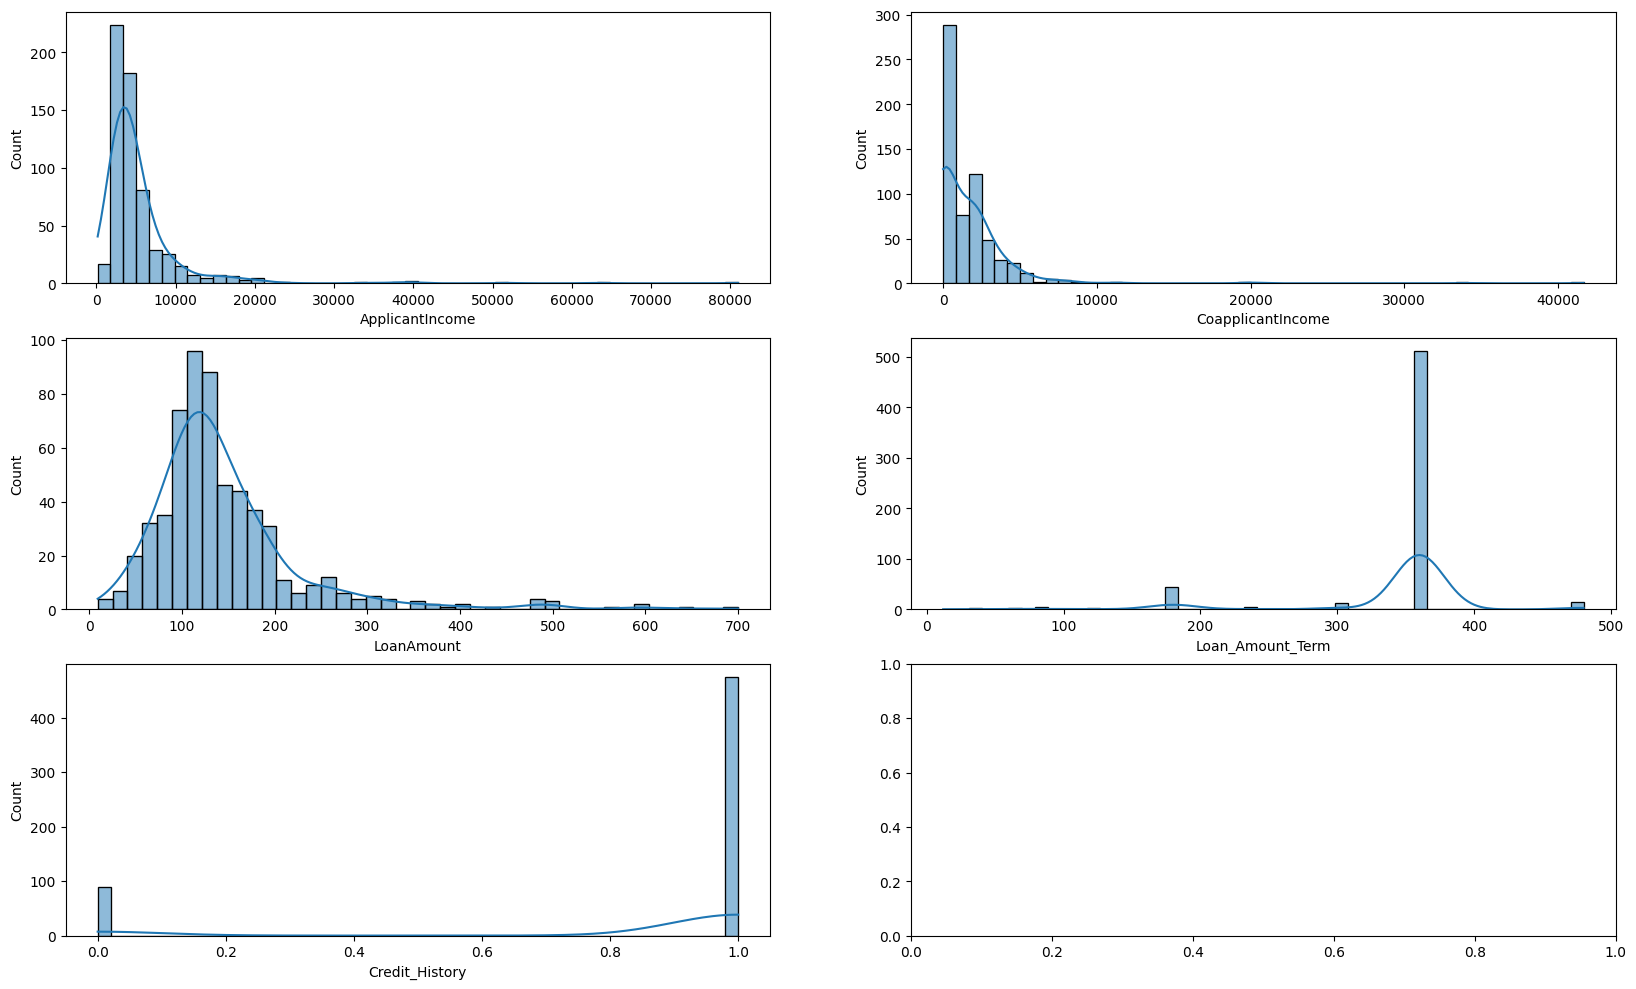

In [1727]:
rowCount = int(np.ceil(len(numberic_cols)/2.0))
fig, ax = plt.subplots(rowCount, 2, figsize=(20,12))
ax = ax.flatten()

for i, col in enumerate(numberic_cols):
    sns.histplot(data=df, x=col, ax=ax[i], kde=True)

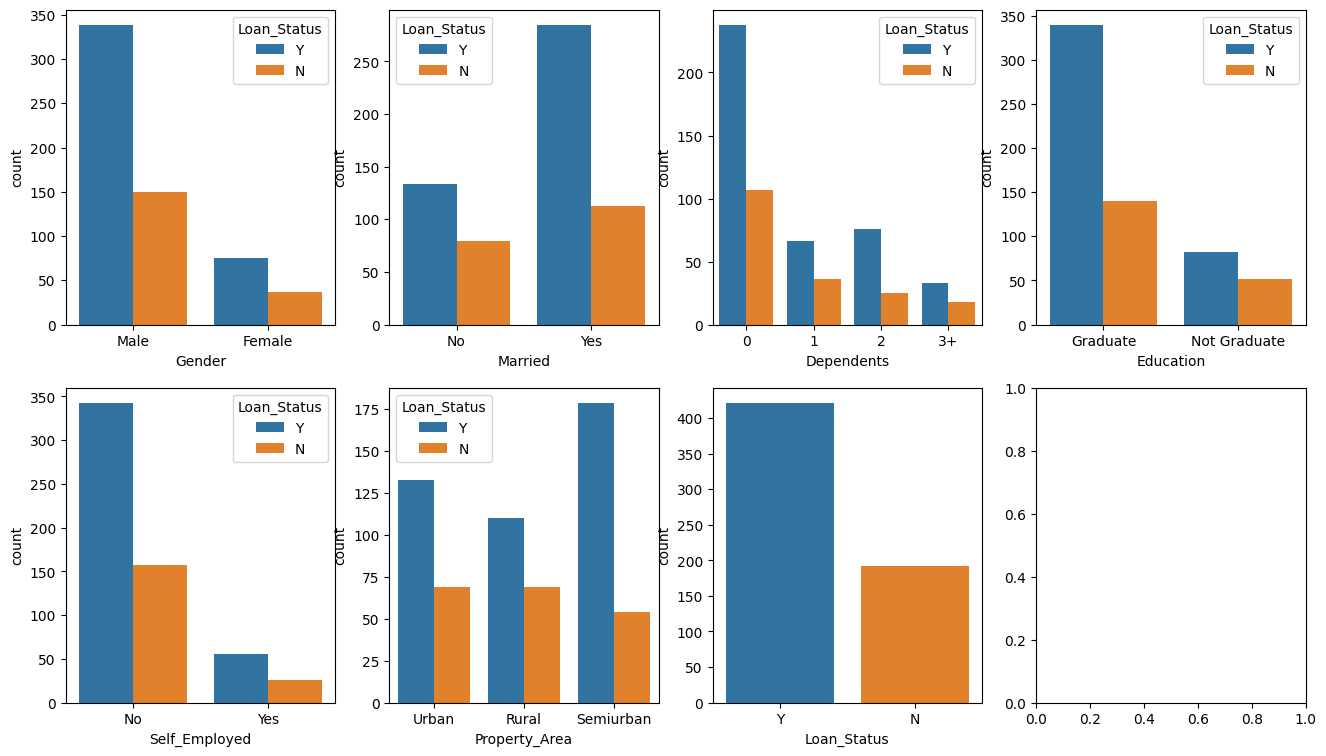

In [1728]:
colCount = 4
rowCount = int(np.ceil(len(object_cols)/colCount))
fig, ax = plt.subplots(rowCount, colCount, figsize=(16,9))
ax = ax.flatten()

for i, col in enumerate(object_cols):
    sns.countplot(data=df, x=col, ax=ax[i], hue='Loan_Status')

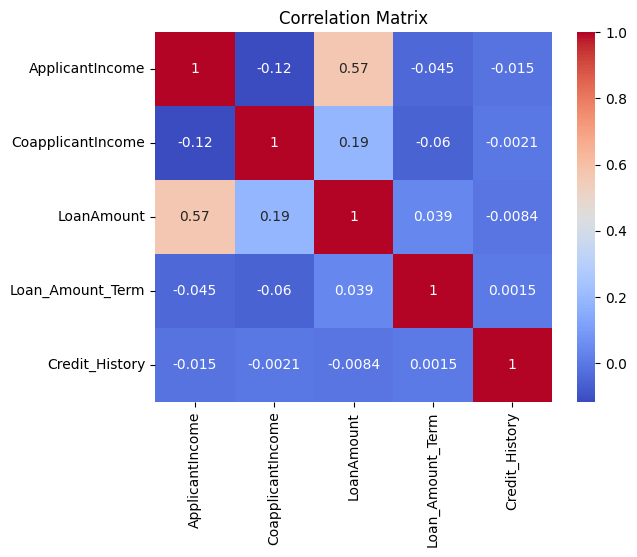

In [1729]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Data Exploration(EDA)

In [1730]:
# df = df.dropna()
# df.drop_duplicates()
df = df.drop(columns=['Loan_ID'])


In [1731]:
updateManual = False

In [1732]:
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [1733]:
# if (updateManual== True):
#cat group 
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0]) 
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0]) 

# num group
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0]) 
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0]) 


In [1734]:
# if (updateManual == True):
#     df = pd.get_dummies(df)
#     df = df.drop(columns=['Gender_Male', 'Married_No', 'Education_Not Graduate', 'Self_Employed_No', 'Loan_Status_N'])
#     newColumnNames = {
#         'Gender_Female': 'Gender', 
#         'Married_Yes': 'Married',
#         'Education_Graduate': 'Education',
#         'Self_Employed_Yes': 'Self_Employed',
#         'Loan_Status_Y': 'Loan_Status'
#     }
#     df = df.rename(columns=newColumnNames)


### Handling Outliers


In [1735]:
numer_cols = list(df.select_dtypes(include=['float','int']).columns)
numer_cols

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

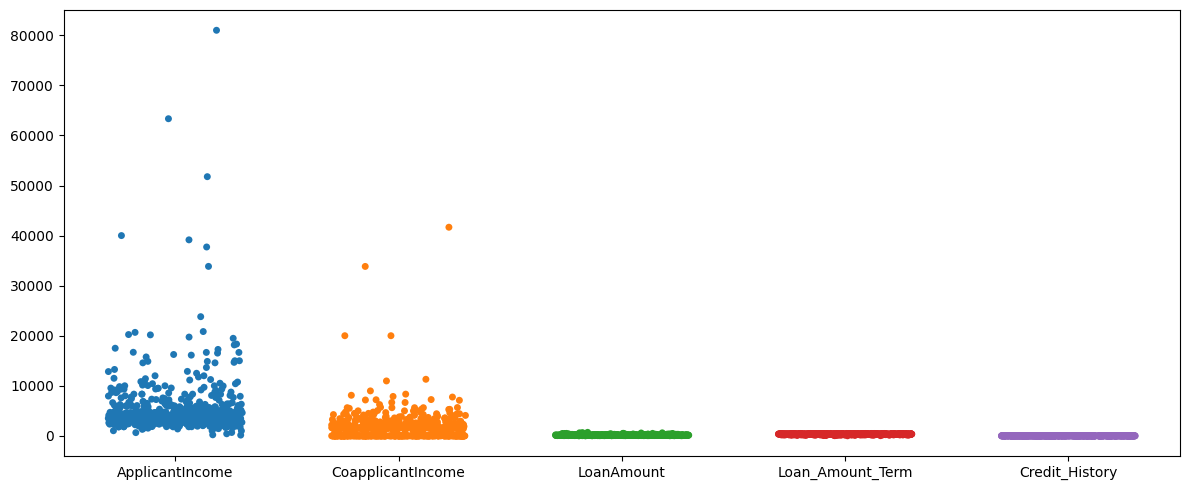

In [1736]:
plt.figure(figsize=(12,5))
sns.stripplot(data=df[numer_cols], jitter=0.3)
plt.tight_layout()
plt.show()

In [1737]:
outliersCols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

Q1 = df[outliersCols].astype('float32').quantile(q=0.25)
Q3 = df[outliersCols].astype('float32').quantile(q=0.75)

IQR = Q3 - Q1 

upper =  Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR
print(upper)
#df[~((df < Q1 - 1.5 * IQR) | (df > Q3 + 1.5 * IQR)).any(axis=1)]


ApplicantIncome      10171.250
CoapplicantIncome     5743.125
LoanAmount             261.500
dtype: float64


In [1738]:
# if (updateManual == True):
for col in outliersCols:
    df = df[~((df[col] < lower[col]) | (df[col] > upper[col]))]

#     df.shape

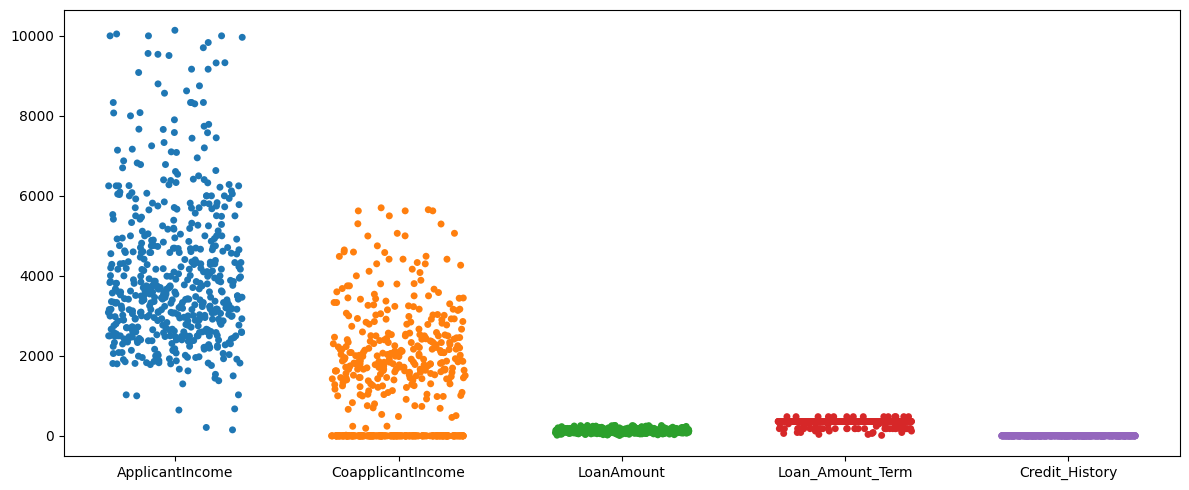

In [1739]:
plt.figure(figsize=(12,5))
sns.stripplot(data=df[numer_cols], jitter=0.3)
plt.tight_layout()
plt.show()

In [1740]:
df.shape

(535, 12)

### Data Preprocessing 

In [1741]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [1742]:
featuresList = X.columns

In [1743]:
# if (updateManual == True):
#     min_max_scaler = MinMaxScaler()
#     X = pd.DataFrame(min_max_scaler.fit_transform(X), columns=featuresList)

In [1744]:
X.shape

(535, 10)

In [1745]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

[link1](https://www.pythontutorials.net/blog/how-to-output-pandas-object-from-sklearn-pipeline/#google_vignette)
[link2](https://www.kaggle.com/code/mohamedkhaledmahmoud/loan-eligibility-prediction-model#2.-Handling-Missing-Values)

In [1746]:
cat_names = list(X_train.select_dtypes(include=['object']).columns)
numer_names = list(X_train.select_dtypes(include=['float','int']).columns)

cat_pl = Pipeline(
    steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder())
    ]
)

num_pl = Pipeline(
    steps=[
        #('imputer', KNNImputer(n_neighbors=7)),
        ('scaler', MinMaxScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pl, numer_names),
        ('cat', cat_pl, cat_names)
    ]
)



### Model Selection 

In [1747]:
final_pl = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(solver='liblinear'))
        ]
    )

final_pl.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [1748]:
models = ['LogisticRegression', 'DecisionTreeClassifier']
accuracy_list = {} 

for model in models:
    if (model == 'LogisticRegression'):
        classifier = ('classifier', LogisticRegression(solver='liblinear'))
    else:
        classifier =  ('classifier', DecisionTreeClassifier()) 
    
    final_pl = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            classifier
        ]
    )

    print(model)
    final_pl.fit(X_train, y_train)

    y_trained_pred = final_pl.predict(X_train)
    y_test_pred = final_pl.predict(X_test)

    acc_train = accuracy_score(y_train, y_trained_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    print(f"------------------{model}------------------")
    print('    ------------------Train data --------------------')
    print(f"Accurary: {acc_train}")
    print(classification_report(y_train, y_trained_pred))
    print('    ------------------Test data --------------------')
    print(f"Accurary: {acc_test}")
    print(classification_report(y_test, y_test_pred))

    accuracy_list[f"{model}_train_data"] = acc_train
    accuracy_list[f"{model}_train_test"] = acc_test

LogisticRegression
------------------LogisticRegression------------------
    ------------------Train data --------------------
Accurary: 0.8130841121495327
              precision    recall  f1-score   support

           N       0.92      0.44      0.59       133
           Y       0.79      0.98      0.88       295

    accuracy                           0.81       428
   macro avg       0.86      0.71      0.74       428
weighted avg       0.83      0.81      0.79       428

    ------------------Test data --------------------
Accurary: 0.8598130841121495
              precision    recall  f1-score   support

           N       1.00      0.50      0.67        30
           Y       0.84      1.00      0.91        77

    accuracy                           0.86       107
   macro avg       0.92      0.75      0.79       107
weighted avg       0.88      0.86      0.84       107

DecisionTreeClassifier
------------------DecisionTreeClassifier------------------
    ------------------Tra

In [1749]:
accuracy_list

{'LogisticRegression_train_data': 0.8130841121495327,
 'LogisticRegression_train_test': 0.8598130841121495,
 'DecisionTreeClassifier_train_data': 1.0,
 'DecisionTreeClassifier_train_test': 0.719626168224299}

In [1750]:
data = preprocessor.transform(X_train)
cols = preprocessor.get_feature_names_out()
rs = pd.DataFrame(data, columns=cols)

In [1751]:
rs.isnull().sum()

num__ApplicantIncome            0
num__CoapplicantIncome          0
num__LoanAmount                 0
num__Loan_Amount_Term           0
num__Credit_History             0
cat__Married_No                 0
cat__Married_Yes                0
cat__Dependents_0               0
cat__Dependents_1               0
cat__Dependents_2               0
cat__Dependents_3+              0
cat__Education_Graduate         0
cat__Education_Not Graduate     0
cat__Self_Employed_No           0
cat__Self_Employed_Yes          0
cat__Property_Area_Rural        0
cat__Property_Area_Semiurban    0
cat__Property_Area_Urban        0
dtype: int64